# Exploratory Analysis for User-Item Interaction
--------

This notebook contains exploration of insights in the data provided before building the Recommender System. The objective of the recommender system is to provide top ten recommended items for a specific user. The input of the recommender system will be the specific `user_id`. Additionally, there will be 3 x expected performance metrics attached to the system.

## Problem Statement
--------

One of the most important problems that sales and marketing team is trying to solve is to bring the right content to their customers - based on their previous interactions. The amount of effort and money spent on sales and marketing is not trivial, in fact, it is huge and therefore, the ability to suggest the most relevant contents to customers is key.

## Sample Data
--------

The data that we have contains information on:
- user id
- item id
- time of interaction

As you can see, we do not have much information on either of the user or item, except the `time of interaction`. Though sounds trivial, it is believed that the time of interaction is actually important in determining how user behaves, for example:
- people tend to wake up later in winter months, ie. Jun - Aug in Australia
- people buy more coffees in the morning than in the afternoon

Therefore, we will do a few analyses with respect to the time of interaction.

## Data Exploration
--------

Before trying to apply any Machine Learning libraries and build the recommender system, we are going to do `exploratory analysis` to surface any interesting insights from the dataset and understand the data deeper, in particular, user behaviour.

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import calendar
import matplotlib.pyplot as plt

### Load Sample Data

The datetime format is in `YYYY-MM-DDThh:mm:ssTZD`, e.g. "1970-01-02T01:17:01+10:00", which is not very nice to read. Let's change the format to a more human-readable format.

In [2]:
# path to sample data
sample_data_path = './data/data.csv'

# define a dateparser to handle timezone offset
date_parser = lambda x: pd.to_datetime(str(x)[:-6])

# load the csv file
df = pd.read_csv(filepath_or_buffer=sample_data_path,
                parse_dates = ['time'],
                date_parser = date_parser)

# assign column names
df.columns = ['user_id', 'item_id', 'interaction_time']

# display the first few rows
df.head()

,user_id,item_id,interaction_time
0,51351,1004251662,1970-01-01 12:22:59
1,51351,1004226560,1970-01-01 12:23:53
2,51351,1004226561,1970-01-01 12:25:44
3,51351,1004226455,1970-01-01 12:28:08
4,51351,1004226454,1970-01-01 12:28:41


The size of the dataset is 65,499 rows x 3 columns.

In [3]:
df.shape

(65499, 3)

Check the data types of each column to ensure they're in the right types for our analysis purposes. They all look good!

In [4]:
df.dtypes

user_id                      int64
item_id                      int64
interaction_time    datetime64[ns]
dtype: object

We will check if there is any missing value in the dataset. Fortunately, all entries look complete, which means we do not need to think about handling missing values for this dataset.

In [5]:
# check if there is missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65499 entries, 0 to 65498
Data columns (total 3 columns):
user_id             65499 non-null int64
item_id             65499 non-null int64
interaction_time    65499 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.5 MB


### Data Cleaning

Let's do a bit of data cleaning, starting with the `interaction_date` column as it is noticeable it contains data from the year of 1970 - it's very odd since the company that owns this data did not exist in 1970.

Let's see the range of datetime in the dataset.

In [6]:
pd.DataFrame(data = [df.interaction_time.min(), df.interaction_time.max()],
            index = ['earliest_interaction', 'latest_interaction'])

,0
earliest_interaction,1970-01-01 12:22:59
latest_interaction,2014-02-25 04:41:11


Let's observe the first few rows in the dataset to see the time period. The first 8 rows are interactions from `1970` and all the rows after that from `2011` onwards. The company who owns this data was only founded in `2011` so there's no way they would have data from `1970`.

A decision needs to be made, we can either drop them or make an assumption that `1970` was an error when recording the data to the system. Also, it is worth noting that `1970` is the beginning time unit for `UNIX` system. Additionally, the `month` and `day` components might be an error as well due to UNIX default timestamp, ie. `1970-01-01` would be the first day since the system started capturing data followed by `1970-01-02` for the following 2nd day and so on. If it is only the `year` component that is replaced, the data will become noticeably discontinous, ie. a few records in `Jan 2011` then gaps until `Nov 2011`.

For the purpose of this analysis, it is decided that we will make the following assumptions:
- the 1970 entries were an error
- data logging started in Nov 2011, 21st

Therefore, `1970-01-01` will be replaced with `2011-11-21`, `1970-01-02` with `2011-11-22` and `2011-01-01` with `2011-11-21`.

note: It should not change the outcome too much since only 9 / 65,499 rows changed - negligible proportion (0.01%)

In [7]:
df.interaction_time.value_counts().sort_index()[0:20]

1970-01-01 12:22:59    1
1970-01-01 12:23:53    1
1970-01-01 12:25:44    1
1970-01-01 12:28:08    1
1970-01-01 12:28:41    1
1970-01-02 01:16:35    1
1970-01-02 01:17:01    1
1970-01-02 14:37:12    1
2011-01-01 23:35:12    1
2011-11-22 07:12:54    1
2011-11-22 07:15:36    1
2011-11-22 07:16:54    1
2011-11-22 07:18:07    1
2011-11-22 07:52:23    1
2011-11-22 07:53:51    1
2011-11-22 07:54:13    1
2011-11-22 09:51:08    1
2011-11-22 13:16:29    1
2011-11-22 13:23:13    1
2011-11-24 11:06:35    1
Name: interaction_time, dtype: int64

In [8]:
df.loc[df.interaction_time.dt.date == datetime.date(datetime(1970, 1, 1)), 'interaction_time'] = df.interaction_time[df.interaction_time.dt.date == datetime.date(datetime(1970, 1, 1))].apply(lambda x: x.replace(year = 2011, month = 11, day = 21))
df.loc[df.interaction_time.dt.date == datetime.date(datetime(1970, 1, 2)), 'interaction_time'] = df.interaction_time[df.interaction_time.dt.date == datetime.date(datetime(1970, 1, 2))].apply(lambda x: x.replace(year = 2011, month = 11, day = 22))
df.loc[df.interaction_time.dt.date == datetime.date(datetime(2011, 1, 1)), 'interaction_time'] = df.interaction_time[df.interaction_time.dt.date == datetime.date(datetime(2011, 1, 1))].apply(lambda x: x.replace(month = 11, day = 21))

df.sort_values('interaction_time', inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(10)

,user_id,item_id,interaction_time
0,51351,1004251662,2011-11-21 12:22:59
1,51351,1004226560,2011-11-21 12:23:53
2,51351,1004226561,2011-11-21 12:25:44
3,51351,1004226455,2011-11-21 12:28:08
4,51351,1004226454,2011-11-21 12:28:41
5,66393,1005032690,2011-11-21 23:35:12
6,78564,1004501787,2011-11-22 01:16:35
7,78564,1004543984,2011-11-22 01:17:01
8,620,1000010578,2011-11-22 07:12:54
9,620,9303,2011-11-22 07:15:36


Our data looks good now with the time range starting from `2011-11-21` onwards.

In [9]:
pd.DataFrame(data = [df.interaction_time.min(), df.interaction_time.max()],
            index = ['earliest_interaction', 'latest_interaction'])

,0
earliest_interaction,2011-11-21 12:22:59
latest_interaction,2014-02-25 04:41:11


This means our data covers just over 2 years of data.

### Data Transformation

#### Time related features
Since we have no features in the sample data, let's derive some time related features from the existing available information: `interaction_time`. From this information, we can derive `interaction_time_of_day`, `interaction_day_of_week` and `interaction_month_of_year`.

In [10]:
# add a column to capture the "date" of the interaction
df = df.assign(interaction_date=df.interaction_time.dt.strftime("%Y-%m-%d"))

# add a column to capture the "month and year" of the interaction
df = df.assign(interaction_month_year=df.interaction_time.dt.strftime("%Y-%m"))

# add a new column to capture the "hour" of the interaction time for each interaction
df = df.assign(interaction_time_of_day=df.interaction_time.dt.hour.values)

## map the hour to time of day, ie. dawn, early morning, morning, afternoon, evening, late evening
time_of_day_conds = [
    (df.interaction_time_of_day >= 1) & (df.interaction_time_of_day < 5),
    (df.interaction_time_of_day >= 5) & (df.interaction_time_of_day < 9),
    (df.interaction_time_of_day >= 9) & (df.interaction_time_of_day < 12),
    (df.interaction_time_of_day >= 12) & (df.interaction_time_of_day < 18),
    (df.interaction_time_of_day >= 18) & (df.interaction_time_of_day < 22)]

time_of_day_values = [
    'dawn',
    'early-morning',
    'morning',
    'afternoon',
    'evening'
]

default_time_of_day_value = 'late-evening'

## map the hour to "time of day" of the interaction
df = df.assign(interaction_time_of_day = np.select(time_of_day_conds, 
                                                 time_of_day_values, 
                                                 default = default_time_of_day_value))

# add a column to capture "day of week" of the interaction
df = df.assign(interaction_day_of_week = df.interaction_time.dt.weekday_name)

# add a new column to contain "month of year" of the interaction
df = df.assign(interaction_month_of_year = df.interaction_time.dt.strftime("%B"))

# add a new column to contain "year" of interaction
df = df.assign(interaction_year = df.interaction_time.dt.strftime("%Y"))

# define custom sorter for time_of_day
time_of_day_sorter = ['early-morning', 'morning', 'afternoon', 'evening', 'late-evening', 'dawn']

# change column type to category so we can use the custom sorter for further analysis later
df.interaction_time_of_day = df.interaction_time_of_day.astype('category')
df.interaction_time_of_day.cat.set_categories(time_of_day_sorter, inplace = True)

#### User related feature
In any sales and marketing related problem, it is important to understand user base growth. Let's derive some features to analyse users' tenure.

In [50]:
df.loc[df.groupby('user_id', as_index = False).head(1).index, 'first_interaction'] = 'first'
df.loc[df.first_interaction.isnull(), 'first_interaction'] = 'repeat'

df = df.assign(first_interaction_date = df.groupby('user_id')['interaction_date'].transform('first'))
df = df.assign(month_since_first_interaction = pd.to_datetime(df.interaction_date) - pd.to_datetime(df.first_interaction_date))
df.loc[:, 'month_since_first_interaction'] = round(df.month_since_first_interaction.dt.days/30,0).astype(int)

# add user_tenure to contain user tenure up to last datetime in the dataset
df = df.assign(user_tenure_in_years = pd.to_datetime(df.interaction_date.max()) - pd.to_datetime(df.first_interaction_date))
df.loc[:, 'user_tenure_in_years'] = round(df.user_tenure_in_years.dt.days/365 * 2) / 2
df.user_tenure_in_years.astype(int, inplace = True)

df.head()

,user_id,item_id,interaction_time,interaction_date,interaction_month_year,interaction_time_of_day,interaction_day_of_week,interaction_month_of_year,interaction_year,first_interaction,month_since_first_interaction,first_interaction_date,user_tenure_in_years
0,51351,1004251662,2011-11-21 12:22:59,2011-11-21,2011-11,afternoon,Monday,November,2011,first,0,2011-11-21,2.5
1,51351,1004226560,2011-11-21 12:23:53,2011-11-21,2011-11,afternoon,Monday,November,2011,repeat,0,2011-11-21,2.5
2,51351,1004226561,2011-11-21 12:25:44,2011-11-21,2011-11,afternoon,Monday,November,2011,repeat,0,2011-11-21,2.5
3,51351,1004226455,2011-11-21 12:28:08,2011-11-21,2011-11,afternoon,Monday,November,2011,repeat,0,2011-11-21,2.5
4,51351,1004226454,2011-11-21 12:28:41,2011-11-21,2011-11,afternoon,Monday,November,2011,repeat,0,2011-11-21,2.5


Now the data is ready. Let's mine some insights from it!

### Insights Mining

#### User-item interactions by time of day
Our initial hypothesis is that the `time of day` might have an impact on user-item interactions. Let's confirm this.

The data shows that most interactions over the 2 year period between Nov 2011 - Feb 2014 were made in the afternoon (12 - 6pm) **31.8%**, followed by evening (6 - 10pm) **19.0%** and dawn (1 - 5am) **14.3%**. The company can use this insight to ensure it has enough staff members to server the users, especially from **12 - 10pm** - the busiest period of the day.

##### - Time of day analysis for items
It is interesting to see that interactions in the afternoon involved much more varieties of items. This could be due to more users were active in the afternoon than in other times.

##### - Time of day analysis for users
Users had more number of interactions with the items in the afternoon and evening compared to other times of the day. Also, we can see that more number of users were active in the afternoon, which is aligned to the most number of different items interacted with (in the time of day analysis for items above). 

In [12]:
time_of_day_df_purchase = \
    df\
        .groupby('interaction_time_of_day', as_index = False)\
        .size()\
        .reset_index(name = 'no_of_interaction')\
        .sort_values('no_of_interaction', ascending = False)

time_of_day_df_purchase = time_of_day_df_purchase.assign(proportion = time_of_day_df_purchase.no_of_interaction / sum(time_of_day_df_purchase.no_of_interaction) * 100)
time_of_day_df_purchase.proportion = time_of_day_df_purchase.proportion.round(decimals=1)

time_of_day_df_purchase = time_of_day_df_purchase.assign(no_of_unique_user = df.groupby('interaction_time_of_day', as_index = False)['user_id'].nunique())
time_of_day_df_purchase = time_of_day_df_purchase.assign(no_of_interactions_per_user = time_of_day_df_purchase.no_of_interaction / time_of_day_df_purchase.no_of_unique_user)

time_of_day_df_purchase = time_of_day_df_purchase.assign(no_of_unique_item = df.groupby('interaction_time_of_day', as_index = False)['item_id'].nunique())

time_of_day_df_purchase.head()

,interaction_time_of_day,no_of_interaction,proportion,no_of_unique_user,no_of_interactions_per_user,no_of_unique_item
2,afternoon,20846,31.8,2443,8.532951,3966
3,evening,12448,19.0,1628,7.646192,2440
5,dawn,9392,14.3,1730,5.428902,1933
1,morning,8677,13.2,1530,5.671242,2696
4,late-evening,7732,11.8,1424,5.429775,1791


#### Top 10 items - overall
Before observing if popular items for different times of day vary, let's take a look at the top 10 items of all time (Nov 2011 - Feb 2014):

In [13]:
top_items = \
    df\
    .groupby(by = ['item_id'])\
    .size()\
    .reset_index(name = 'no_of_interaction')\
    .sort_values('no_of_interaction', ascending = False)\
    .reset_index(drop = True)

top_items = top_items.assign(rank_n = 'rank ' + (top_items.index + 1).astype(str) + ' overall')

# create a dictionary of top items to be used later
rank_item_map = dict(top_items.set_index('item_id').rank_n)

top_items.head(10)

,item_id,no_of_interaction,rank_n
0,1004202413,1213,rank 1 overall
1,1000250281,941,rank 2 overall
2,1000240980,796,rank 3 overall
3,1000328335,728,rank 4 overall
4,1000304943,715,rank 5 overall
5,1000240957,711,rank 6 overall
6,1000304945,673,rank 7 overall
7,1004202479,614,rank 8 overall
8,1000268407,491,rank 9 overall
9,1000304944,483,rank 10 overall


#### Items by time of day
Let's take a more detailed look on popular items by interaction time of day. When looking at the top 5 items across different times of day, there is a slight variation:
- item_id `1004202413`: This item was the most popular for dawn, early morning, morning and afternoon
- item_id `1000250281` and `1000240980`: These items were the most popular ones for evening to late evening

This finding supported our hypothesis above that time of day does have an impact on user's interaction with different items. In other words, some items are more popular in certain times of day than others.

In [14]:
# create the base dataframe for time of day insights
time_of_day_df_item = \
    df\
    .groupby(by = ['interaction_time_of_day', 'item_id'])\
    .size()\
    .reset_index(name = 'no_of_interaction')\
    .sort_values('no_of_interaction', ascending = False)

time_of_day_df_top_item = time_of_day_df_item\
                        .groupby('interaction_time_of_day')\
                        .head(5)\
                        .reset_index(drop=True)\
                        .sort_values(['interaction_time_of_day', 'no_of_interaction'],
                                     ascending = [True, False])

time_of_day_df_top_item = time_of_day_df_top_item.assign(overall_rank_n = time_of_day_df_top_item.item_id.map(rank_item_map))

time_of_day_df_top_item

,interaction_time_of_day,item_id,no_of_interaction,overall_rank_n
3,early-morning,1004202413,304,rank 1 overall
13,early-morning,1004202479,180,rank 8 overall
22,early-morning,1000304943,119,rank 5 overall
27,early-morning,1000304945,95,rank 7 overall
29,early-morning,1000304944,79,rank 10 overall
14,morning,1004202413,166,rank 1 overall
23,morning,1000304945,112,rank 7 overall
24,morning,1000304943,107,rank 5 overall
25,morning,1004183308,106,rank 14 overall
28,morning,1000304944,84,rank 10 overall


#### Top 10 users
After observing items popularity, let's investigate users behaviour. The following are the top 10 users of all time (Nov 2011 - Feb 2014):

In [15]:
top_users = \
    df\
    .groupby('user_id')\
    .size()\
    .reset_index(name = 'no_of_interactions')\
    .sort_values('no_of_interactions', ascending = False)\
    .reset_index(drop = True)

top_users = top_users.assign(rank_n = 'rank ' + (top_users.index + 1).astype(str) + ' overall')

# create a dictionary of top items to be used later
rank_user_map = dict(top_users.set_index('user_id').rank_n)

top_users.head(10)

,user_id,no_of_interactions,rank_n
0,12281,625,rank 1 overall
1,4412,569,rank 2 overall
2,4402,495,rank 3 overall
3,325,492,rank 4 overall
4,13384,417,rank 5 overall
5,21168,395,rank 6 overall
6,3528,377,rank 7 overall
7,1181,375,rank 8 overall
8,3134,346,rank 9 overall
9,1334,341,rank 10 overall


#### User by time of day

By looking at the top users based on their number of interactions throughout the day, we found the following:
- the top user `12281` was most active in the evening and late evening, with little activity at dawn as well
- our second top user `4412` was most active in the afternoon

Based on this finding, we can infer that time of day does have an impact on user's behaviour. In other words, some users prefer to make their interaction in certain times of day.

In [16]:
# create the base dataframe for time of day insights
time_of_day_df_user = \
    df\
    .groupby(by = ['interaction_time_of_day', 'user_id'])\
    .size()\
    .reset_index(name = 'no_of_interaction')\
    .sort_values('no_of_interaction', ascending = False)

time_of_day_df_user_top = time_of_day_df_user\
                        .groupby('interaction_time_of_day')\
                        .head(5)\
                        .reset_index(drop=True)\
                        .sort_values(['interaction_time_of_day', 'no_of_interaction'],
                                     ascending = [True, False])

time_of_day_df_user_top = time_of_day_df_user_top.assign(overall_rank_n = time_of_day_df_user_top.user_id.map(rank_user_map))

time_of_day_df_user_top

,interaction_time_of_day,user_id,no_of_interaction,overall_rank_n
20,early-morning,325,90,rank 4 overall
22,early-morning,3528,87,rank 7 overall
23,early-morning,6624,85,rank 28 overall
28,early-morning,1180,55,rank 15 overall
29,early-morning,4863,47,rank 18 overall
7,morning,21168,163,rank 6 overall
8,morning,4402,150,rank 3 overall
11,morning,1181,128,rank 8 overall
12,morning,4412,123,rank 2 overall
18,morning,1334,102,rank 10 overall


#### User-item interaction by volume
Some users had interacted with the same product for 100 - 200 times.

In [23]:
user_item_interaction_volume = \
    df\
    .groupby(['user_id', 'item_id'])\
    .size()\
    .reset_index(name = 'user_item_interaction_count')\
    .sort_values('user_item_interaction_count', ascending = False)

user_item_interaction_volume.head()

,user_id,item_id,user_item_interaction_count
10906,12281,1000240980,207
62,325,1000011143,179
10909,12281,1000250281,152
65,325,1000164185,124
63,325,1000163994,116


#### User by year
The chart shows significant increase in the number of unique users who had at least 1 interaction between 2012 and 2013 (a user who had an interaction in both 2012 and 2013 will be counted as 1 user in each of the year). It is approximately 500% increase. This number is really high and sometimes, it may be because:
- prior to 2013, the company was using a different database system and this data that we are analysis is from the new system (migration of data from the old system to the new system had not been completed yet)
- accident that caused in missing data during the period between 2012 and 2013
- or it is simply because the company just made a huge growth, which is fantastic!

In the following sections we will look in deeper time granularity to see if we can surface further insights on this.

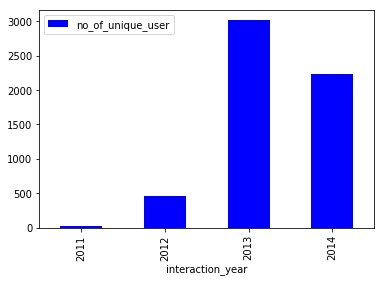

In [18]:
unique_user_by_year = df.groupby('interaction_year')['user_id'].nunique().reset_index(name = 'no_of_unique_user')

unique_user_by_year.plot(x = 'interaction_year',
                         y = 'no_of_unique_user',
                         kind = 'bar',
                         color = 'blue')

plt.show()

#### User by month
Let's observe monthly user activity. From this chart, it is evident that the number of unique user who had at least one interaction was growing consistently on a monthly basis starting from Jan 2013.

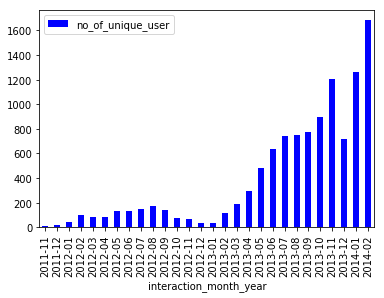

In [19]:
unique_user_by_month = df.groupby('interaction_month_year')['user_id'].nunique().reset_index(name = 'no_of_unique_user')

unique_user_by_month.plot(x = 'interaction_month_year',
                         y = 'no_of_unique_user',
                         kind = 'bar',
                         color = 'blue')

plt.show()

#### Number of unique new users by year
The above 2 charts have demonstrated significant increase in users who were active but we cannot tell how many new users there were in each year. Let's take a look at it.

In 2013, the company did sign up a lot of new users compared to 2012.

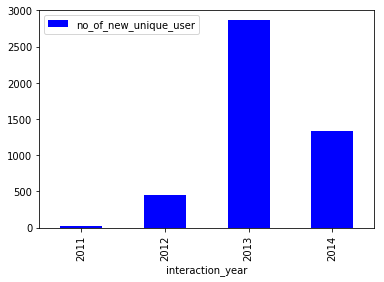

In [20]:
new_unique_user_by_year = df.loc[df.first_interaction == 'first',:].groupby('interaction_year')['user_id'].nunique().reset_index(name = 'no_of_new_unique_user')

new_unique_user_by_year.plot(x = 'interaction_year',
                         y = 'no_of_new_unique_user',
                         kind = 'bar',
                         color = 'blue')

plt.show()

#### Number of unique new users by month
Let's take a look at the number of unique new users growth by month. It seems like there was positive growth of new customer base month by month in 2013.

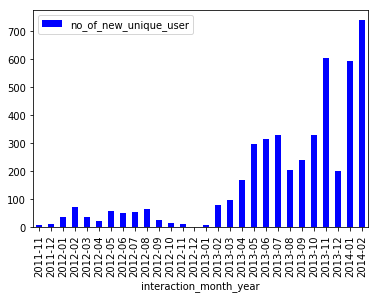

In [21]:
new_unique_user_by_month = df.loc[df.first_interaction == 'first',:].groupby('interaction_month_year')['user_id'].nunique().reset_index(name = 'no_of_new_unique_user')

new_unique_user_by_month.plot(x = 'interaction_month_year',
                         y = 'no_of_new_unique_user',
                         kind = 'bar',
                         color = 'blue')

plt.show()

#### User tenure in years analysis
Most of the users were still new with a tenure of less than a year (approximately 80%) as a lot of them had just joined in 2013.

In [49]:
user_tenure_distribution = \
    df\
    .groupby('user_tenure_in_years')['user_id']\
    .nunique()\
    .reset_index(name = 'no_of_unique_user')

user_tenure_distribution = user_tenure_distribution.assign(proportion = user_tenure_distribution.no_of_unique_user / sum(user_tenure_distribution.no_of_unique_user) * 100)
user_tenure_distribution.loc[:,'proportion'] = round(user_tenure_distribution.proportion, 1)

user_tenure_distribution

,user_tenure_in_years,no_of_unique_user,proportion
0,0.0,1587,34.1
1,0.5,2004,43.1
2,1.0,607,13.0
3,1.5,234,5.0
4,2.0,217,4.7
5,2.5,6,0.1


#### User-item interaction trend analysis

The number of interaction per user seems to be steady during the period from Nov 2011 - Feb 2014, except a huge spike in December 2012 (could be error in data or a massive promotion launched after the company was founded in Nov 2011). However, it does not look like the number of interaction per user was affected by seasons/ months of year since then.

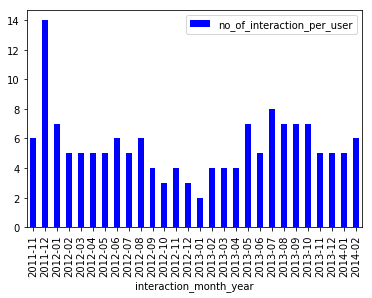

In [22]:
interaction_per_user = df.groupby('interaction_month_year')['user_id'].nunique().reset_index(name = 'no_of_unique_user')

interaction_per_user = interaction_per_user.assign(no_of_interactions = df.groupby('interaction_month_year', as_index=False).size().reset_index(drop=True))

interaction_per_user = interaction_per_user.assign(no_of_interaction_per_user = round(interaction_per_user.no_of_interactions / interaction_per_user.no_of_unique_user, 0))

interaction_per_user.plot(x = 'interaction_month_year',
                         y = 'no_of_interaction_per_user',
                         kind = 'bar',
                         color = 'blue')

plt.show()

### Insights Summary

- User interacts with more items in the afternoon and evening compared to other times of day
- Some items were interacted with more often in certain times of day
- It is inferred that time of day might actually have an impact on user-item interaction